In [2]:
import pandas as pd

#dataset
data = pd.read_csv('/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv', header=None, names=['userId', 'productId', 'Rating', 'timestamp'])
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
print(data.shape)  #number of rows and columns
print(data.isnull().sum())  #missing values

(7824482, 4)
userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


Data Preprocessing

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
print(data['Rating'].describe())  #Summary of ratings

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64


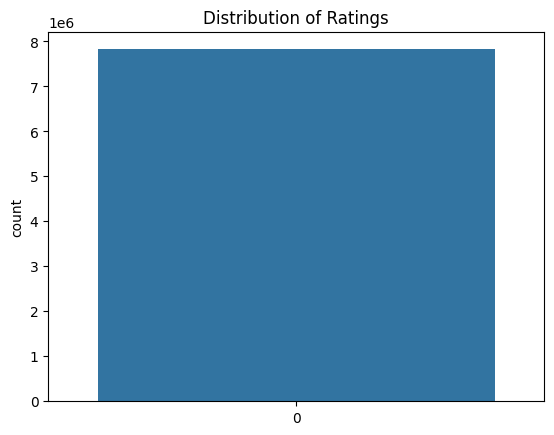

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data['Rating'])
plt.title('Distribution of Ratings')
plt.show()

 Build the Recommendation Model

In [6]:
# Set thresholds for active users and products
min_user_ratings = 20
min_product_ratings = 50

# Filter users who rated at least min_user_ratings products
active_users = data['userId'].value_counts()[data['userId'].value_counts() >= min_user_ratings].index
filtered_data = data[data['userId'].isin(active_users)]

# Filter products that have been rated at least min_product_ratings times
active_products = filtered_data['productId'].value_counts()[filtered_data['productId'].value_counts() >= min_product_ratings].index
filtered_data = filtered_data[filtered_data['productId'].isin(active_products)]

# Create the user-item matrix
user_item_matrix = filtered_data.pivot_table(index='userId', columns='productId', values='Rating').fillna(0)

# Check the shape of the resulting matrix
print(user_item_matrix.shape)

(12933, 880)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

#Product similarity using the user-item matrix
item_similarity = cosine_similarity(user_item_matrix.T)

#DF for better readability
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

print(item_similarity_df.shape)
print(item_similarity_df.head())

(880, 880)
productId   B00001P4ZH  B00001WRSJ  B00004SB92  B00004T8R2  B00004THCZ  \
productId                                                                
B00001P4ZH    1.000000    0.021493    0.000000    0.051590         0.0   
B00001WRSJ    0.021493    1.000000    0.005548    0.023704         0.0   
B00004SB92    0.000000    0.005548    1.000000    0.000000         0.0   
B00004T8R2    0.051590    0.023704    0.000000    1.000000         0.0   
B00004THCZ    0.000000    0.000000    0.000000    0.000000         1.0   

productId   B00004WCID  B00004Z5M1  B00004ZC8Y  B00004ZCJE  B0000510ZO  ...  \
productId                                                               ...   
B00001P4ZH    0.000000    0.016385    0.009686    0.003931     0.01389  ...   
B00001WRSJ    0.000000    0.013116    0.000000    0.014749     0.00000  ...   
B00004SB92    0.000000    0.030454    0.000000    0.020928     0.00000  ...   
B00004T8R2    0.000000    0.026022    0.013353    0.000000     0.00000  ...

In [19]:
def get_recommendations(product_id, n=5):
    if product_id not in item_similarity_df.columns:
        return f"Product ID '{product_id}' not found in the dataset."
    
    #Get the similarity scores for the given product
    similar_scores = item_similarity_df[product_id]
    
    #Sort scores and select the top n similar products
    similar_products = similar_scores.sort_values(ascending=False).head(n + 1)  #+1 to include the product itself
    return similar_products.index[1:]  

#Example
recommendations = get_recommendations('B00001P4ZH', n=6)  
print("Recommended Products:", recommendations)


Recommended Products: Index(['B000089GN3', 'B0006B486K', 'B00007056H', 'B00004T8R2', 'B000AJIF4E',
       'B00APCMMDG'],
      dtype='object', name='productId')


Visualize the recommendations

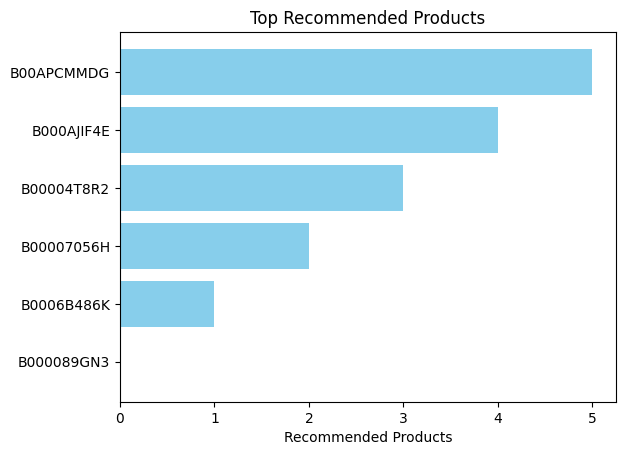

In [20]:
recommended_products = get_recommendations('B00001P4ZH', n=6)

product_mapping = pd.Series(data['productId'].unique(), index=data['productId'].unique())

product_names = product_mapping.get(recommended_products, 'Unknown Product').values

plt.barh(product_names, range(len(product_names)), color='skyblue')
plt.xlabel('Recommended Products')
plt.title('Top Recommended Products')
plt.show()